In [62]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf
import optuna.visualization as vis
import plotly
import optuna
from omegaconf import DictConfig, OmegaConf
from tornado.util import re_unescape

import DataInit
from DataInit import DataManager, RewardDataManager
from pathlib import Path

In [63]:
# 配置管理
config = DataInit.config_manager()

# 路径管理
global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = DataInit.path_manager(config)

---------- Config Info ----------
path:
  global_path: /home/alex4060/PythonProject/MScProject/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda_load: 0.5
  top_k:
  - 1
  - 2
  - 3
  - 4
  - 5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_std: 10.0
    node_load_iid_std: 5.0
    node_load_ar1_theta: 0.9
    node_load_ar1_std: 80.0
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_std: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 30.0
      alpha_latency_1: 0.035
    ar1:
      alpha_load_0: 30.0
      alpha_latency_1: 0.086
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
   

In [64]:
# 加载数据
iid_load_data_manager = DataInit.import_data_manager(models_pkl_path, 'iid_load', if_print=False)
ar1_load_data_manager = DataInit.import_data_manager(models_pkl_path, 'ar1_load', if_print=False)
iid_latency_data_manager = DataInit.import_data_manager(models_pkl_path, 'iid_latency', if_print=False)
ar1_latency_data_manager = DataInit.import_data_manager(models_pkl_path, 'ar1_latency', if_print=False)
reward_data_manager = DataInit.import_data_manager(models_pkl_path, 'reward', if_print=False)

/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import List, Tuple, Optional
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
import torch.optim.lr_scheduler as lr_scheduler


In [66]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.layer_norm(out[:, -1, :])
        out = F.relu(out)
        out = self.fc(out)
        return out

In [67]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob=0.5):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)  # LSTM层
#         self.layer_norm = nn.LayerNorm(hidden_size)  # 层归一化
#         self.dropout = nn.Dropout(dropout_prob)  # Dropout层        
#         self.fc = nn.Linear(hidden_size, output_size)  # 全连接层
# 
#     def forward(self, x):
#         h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h_0, c_0))  # LSTM层的输出
#         out = self.layer_norm(out[:, -1, :])  # 对最后一个时间步进行层归一化
#         out = self.dropout(out)  # 应用Dropout
#         out = F.relu(out)  # 应用ReLU激活函数
#         out = self.fc(out)  # 全连接层输出
# 
#         return out


In [68]:
class EarlyStopping:
    def __init__(self, patience_epochs=5, min_delta=1e-2):
        self.patience_epochs = patience_epochs
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, train_loss):
        if self.best_loss is None:
            self.best_loss = train_loss
        elif train_loss < self.best_loss - self.min_delta:
            self.best_loss = train_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience_epochs:
                self.early_stop = True

In [69]:
from torch.nn import HuberLoss

In [79]:
class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, y_pred, y_true):
        loss = torch.log(torch.cosh(y_pred - y_true))
        return torch.mean(loss)

In [119]:
class LSTMTraining:
    def __init__(self, config: dict, data_manage: object, model_type:str='lstm') -> None:
        # 判断是LSTM还是GNN
        self.model_type = model_type
        
        # 从 config 提取基础参数
        self.T_train: int = config['base']['T_train']
        self.T_val: int = config['base']['T_val']
        self.T_test: int = config['base']['T_test']

        # 从 config 提取 LSTM 模型参数
        
        self.seq_length: int = config['exp4']['seq_length']
        self.input_size: int = config['exp4']['input_size']
        self.output_size: int = config['exp4']['output_size']

        self.num_epochs: int = config['exp4']['num_epochs']
        self.device: str = config['exp4']['device']
        self.mix_precision: bool = config['exp4']['mix_precision']
        
        self.model: nn.Module = LSTMModel(
            input_size=self.input_size,
            hidden_size=config['exp4']['LSTMconfig']['hidden_size'],
            output_size=self.output_size,
            num_layers=config['exp4']['LSTMconfig']['num_layers'],
        ).to(self.device)

        # 优化器、损失函数、学习率调度器、早停
        # self.criterion: nn.Module = nn.MSELoss()
        self.criterion: nn.Module = HuberLoss(delta=1000.0)  # delta 参数可以根据需要进行调整
        # self.criterion: nn.Module = LogCoshLoss()
        self.optimizer: optim.Optimizer = optim.Adam(
            self.model.parameters(), 
            lr=config['exp4']['learning_rate'],
            # weight_decay=config['exp4']['LSTMconfig']['weight_decay']  # L2正则化
        )
        self.scheduler: lr_scheduler.ReduceLROnPlateau = lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=config['exp4']['mode'],
            factor=config['exp4']['factor'],
            patience=config['exp4']['patience_lr'],
            min_lr=config['exp4']['min_lr'],
            threshold=config['exp4']['threshold']
        )
        self.early_stopping: EarlyStopping = EarlyStopping(patience_epochs=config['exp4']['patience_epochs'], min_delta=config['exp4']['min_delta'])
        self.scaler: Optional[torch.amp.GradScaler] = torch.amp.GradScaler() if config['exp4']['mix_precision'] else None

        # 数据管理
        self.train_dataloader: DataLoader = data_manage.train_dataloader
        self.val_dataloader: DataLoader = data_manage.val_dataloader
        self.test_data_tensor: torch.Tensor = data_manage.test_data_tensor
        
        # 获取完整tarin_val的tensor数据，用于截取最后一组，对test的第一个进行预测
        self.train_val_data_tensor: torch.Tensor = data_manage.train_val_data_tensor
        
        self.train_data_np: np.ndarray = data_manage.train_data_np
        self.val_data_np: np.ndarray = data_manage.val_data_np
        self.test_data_np: np.ndarray = data_manage.test_data_np

        # # 从 data_manage 模块中获取边索引张量
        # edge_index = data_manage.edge_index_tensor

        # 用于记录预测值
        self.train_predictions: Optional[torch.Tensor] = None
        self.val_predictions: Optional[torch.Tensor] = None
        self.test_predictions: Optional[torch.Tensor] = None
        
        # 记录损失
        self.train_losses: List[float] = []
        self.val_losses: List[float] = []
        self.fine_tune_losses: List[float] = []

        # 记录学习率变化
        self.train_with_val_learning_rates: List[float] = []
        self.fine_tune_learning_rates: List[float] = []

        # 记录扩展的学习率
        self.train_extended_lr: Optional[np.ndarray] = None
        self.val_extended_lr: Optional[np.ndarray] = None

    def train_epoch(self, epoch: int) -> Tuple[float, torch.Tensor]:
        self.model.train()  # Ensure model is in training mode
        train_cumulative_loss: float = 0.0  # 训练集累积损失
        epoch_train_pred: torch.Tensor = torch.zeros((self.T_train, self.output_size), device=self.device)
        train_start_idx: int = 20  # 预测初始index值

        for train, val in self.train_dataloader:
            batch_size: int = train.size(0)
            end_idx: int = train_start_idx + batch_size
            train, val = train.to(self.device, non_blocking=True).float(), val.to(self.device, non_blocking=True).float()

            self.optimizer.zero_grad()  # Reset gradients

            if self.mix_precision:  # Mixed precision training
                with torch.amp.autocast(device_type=self.device):
                    train_pred: torch.Tensor = self.model(train)  # 前向传播, shape: [batch_size, output_size], [64, 10]
                    train_loss: torch.Tensor = self.criterion(train_pred, val)
                self.scaler.scale(train_loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                train_pred: torch.Tensor = self.model(train)
                train_loss: torch.Tensor = self.criterion(train_pred, val)
                train_loss.backward()
                self.optimizer.step()

            # 将当前批次的预测结果填入对应位置
            epoch_train_pred[train_start_idx:end_idx] = train_pred.detach()
            # print(f'Train start index: {train_start_idx}, End index: {end_idx}')
            train_start_idx = end_idx
            self.train_losses.append(train_loss.item())    # Record single training loss
            train_cumulative_loss += train_loss.item()

        return train_cumulative_loss, epoch_train_pred

    def validate_epoch(self) -> Tuple[float, torch.Tensor]:
        self.model.eval()  # Ensure model is in evaluation mode
        val_cumulative_loss: float = 0.0
        epoch_val_pred: torch.Tensor = torch.zeros((self.T_val, self.output_size), device=self.device)
        val_start_idx: int = 0  # 预测值起始位置
        
        with torch.no_grad():
            for val_input, val_target in self.val_dataloader:
                batch_size: int = val_input.size(0)
                
                end_idx: int = val_start_idx + batch_size

                val_input, val_target = val_input.to(self.device, non_blocking=True).float(), val_target.to(self.device, non_blocking=True).float()

                if self.mix_precision: # 混合精度推断
                    with torch.amp.autocast(device_type=self.device):
                        val_pred: torch.Tensor = self.model(val_input)
                        val_loss: torch.Tensor = self.criterion(val_pred, val_target)
                else:
                    val_pred: torch.Tensor = self.model(val_input)
                    val_loss: torch.Tensor = self.criterion(val_pred, val_target)

                # 将当前批次的预测结果填入对应位置
                epoch_val_pred[val_start_idx:end_idx] = val_pred.detach()
                val_start_idx = end_idx  # 更新起始索引
                self.val_losses.append(val_loss.item())  # Record single validation loss
                val_cumulative_loss += val_loss.item()

        return val_cumulative_loss, epoch_val_pred

    def train(self) -> None:
        for epoch in tqdm(range(self.num_epochs), desc="Training"):
            train_cumulative_loss, epoch_train_pred = self.train_epoch(epoch)
            val_cumulative_loss, epoch_val_pred = self.validate_epoch()

            # 计算训练和验证的平均损失
            train_avg_loss: float = train_cumulative_loss / len(self.train_dataloader)
            val_avg_loss: float = val_cumulative_loss / len(self.val_dataloader)

            # 早停机制基于验证集损失
            self.early_stopping(val_avg_loss)
            if self.early_stopping.early_stop:
                print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
                break

            # 调度器更新基于验证集损失
            self.scheduler.step(val_avg_loss)
            
            # 动态学习率
            current_lr: float = self.scheduler.optimizer.param_groups[0]['lr']
            self.train_with_val_learning_rates.append(current_lr)

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train_Loss: {train_avg_loss:.4f}, Val_Loss: {val_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

                # if torch.cuda.is_available():  # 释放GPU缓存
                #     torch.cuda.empty_cache()

        self.train_predictions = epoch_train_pred
        self.val_predictions = epoch_val_pred

        # 训练结束后计算扩展的学习率
        self.compute_extended_learning_rates()

        print(f"Training finished after {epoch + 1} epochs.")
        print(f"Average loss per epoch: {train_avg_loss:.4f}, Validation loss: {val_avg_loss:.4f}")

    def fine_tune(self) -> None:
        tune_cumulative_loss: float = 0.0
        predictions: torch.Tensor = torch.zeros((self.T_test, self.output_size), device=self.device)
        input_data: torch.Tensor = self.train_val_data_tensor[:, -self.seq_length:].T.unsqueeze(0).to(self.device)

        for i in tqdm(range(self.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # Keep model in training mode for fine-tuning
            pred: torch.Tensor = self.model(input_data)
            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]


            loss: torch.Tensor = self.criterion(pred.squeeze(0), self.test_data_tensor[:, i])    # 计算损失
            self.fine_tune_losses.append(loss.item())    # 记录单次损失
            tune_cumulative_loss += loss.item()    # 累加损失

            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 在每个epoch结束时，计算验证集的平均损失
            tune_avg_loss: float = tune_cumulative_loss / (i + 1)

            # 调度器更新（可选，基于微调期间的损失）
            self.scheduler.step(tune_avg_loss)
            current_lr: float = self.scheduler.get_last_lr()[0]
            self.fine_tune_learning_rates.append(current_lr)

            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.T_test}, Loss: {tune_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')
            
            # 更新输入序列 
            input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(0).unsqueeze(1)), dim=1)

        print(f'Cumulative Fine-tuning loss:{tune_cumulative_loss:.4f}')
        print(f'Average Fine-tuning Loss over {self.T_test} steps: {tune_avg_loss:.4f}')
        self.test_predictions = predictions
        
    def compute_extended_learning_rates(self) -> None:
        """计算用于绘图的扩展学习率数组"""
        train_steps = len(self.train_losses)
        val_steps = len(self.val_losses)
        num_epochs = len(self.train_with_val_learning_rates)

        train_repeats_per_epoch = train_steps // num_epochs
        val_repeats_per_epoch = val_steps // num_epochs

        self.train_extended_lr = np.repeat(self.train_with_val_learning_rates, train_repeats_per_epoch)
        train_remaining_steps = train_steps - len(self.train_extended_lr)
        if train_remaining_steps > 0:
            self.train_extended_lr = np.append(self.train_extended_lr, [self.train_with_val_learning_rates[-1]] * train_remaining_steps)

        self.val_extended_lr = np.repeat(self.train_with_val_learning_rates, val_repeats_per_epoch)
        val_remaining_steps = val_steps - len(self.val_extended_lr)
        if val_remaining_steps > 0:
            self.val_extended_lr = np.append(self.val_extended_lr, [self.train_with_val_learning_rates[-1]] * val_remaining_steps)

    def plot_loss(self) -> None:
        """绘制训练和验证的损失曲线"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Losses')
        plt.plot(self.val_losses, label='Validation Losses')
        plt.title('Training and Validation Loss over Time')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_loss_and_lr(self) -> None:
        """同时绘制训练损失、验证损失和学习率变化曲线"""
        fig, ax1 = plt.subplots(figsize=(12, 6))
    
        color = 'tab:red'
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(range(len(self.train_losses)), self.train_losses, label='Train Loss', color='tab:red')
        ax1.plot(range(len(self.val_losses)), self.val_losses, label='Val Loss', color='tab:orange')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
    
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Learning Rate', color=color)
        ax2.plot(range(len(self.train_with_val_learning_rates)), self.train_with_val_learning_rates, label='Training LR', linestyle='--', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')
    
        fig.tight_layout()
        plt.title('Loss and Learning Rate over Time')
        plt.grid(True)
        plt.show()

    def plot_full(self, i: int) -> None:
        """绘制完整的训练、验证和测试集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制训练集预测与实际值
        plt.plot(range(self.T_train), self.train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions', linestyle='--')
        plt.plot(range(self.T_train), self.train_data_np[i, :], label='Train Actual')

        # 绘制验证集预测与实际值
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions', linestyle='--')
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_data_np[i, :], label='Val Actual')

        # 绘制测试集预测与实际值
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions', linestyle='--')
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_data_np[i, :], label='Test Actual')

        # 标记训练集、验证集和测试集的边界
        plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
        plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')

        plt.legend()
        plt.title('Full Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_train(self, i: int) -> None:
        """绘制训练集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制训练集预测与实际值
        plt.plot(range(self.T_train), self.train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions', linestyle='--')
        plt.plot(range(self.T_train), self.train_data_np[i, :], label='Train Actual')

        plt.legend()
        plt.title('Train Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_val(self, i: int) -> None:
        """绘制验证集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制验证集预测与实际值
        plt.plot(range(self.T_val), self.val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions', linestyle='--')
        plt.plot(range(self.T_val), self.val_data_np[i, :], label='Val Actual')

        plt.legend()
        plt.title('Validation Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_test(self, i: int) -> None:
        """绘制测试集的预测与实际值对比图"""
        plt.figure(figsize=(15, 6))

        # 绘制测试集预测与实际值
        plt.plot(range(self.T_test), self.test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions', linestyle='--')
        plt.plot(range(self.T_test), self.test_data_np[i, :], label='Test Actual')

        plt.legend()
        plt.title('Test Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_range(self, start: int, end: int, i: int) -> None:
        """在指定范围内绘制预测值与实际值的对比图"""
        total_length = self.T_train + self.T_val + self.T_test
        if start < 0 or end > total_length or start >= end:
            raise ValueError(f"Invalid range: start={start}, end={end}. Check the range values.")

        # 拼接训练、验证和测试集的预测结果
        full_data = torch.cat([self.train_predictions.detach(), self.val_predictions.detach(), self.test_predictions.detach()], dim=0).cpu().numpy()
        full_actual = np.concatenate([self.train_data_np, self.val_data_np, self.test_data_np], axis=1)

        if i < 0 or i >= full_actual.shape[0]:
            raise ValueError(f"Invalid node index: i={i}. Check the node index.")

        plt.figure(figsize=(15, 6))

        # 在指定范围内绘制第 i 个节点的预测值与实际值
        plt.plot(range(start, end), full_data[start:end, i], label='Predictions', linestyle='--')
        plt.plot(range(start, end), full_actual[i, start:end], label='Actual')

        plt.legend()
        plt.title(f'Prediction vs Actual for Node {i} from {start} to {end}')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_all_losses_and_lr_0(self) -> None:
        """绘制训练、验证、微调的损失和学习率曲线"""
        if self.train_extended_lr is None or self.val_extended_lr is None:
            raise ValueError("Learning rates have not been computed. Call compute_extended_learning_rates() first.")

        fig, axs = plt.subplots(3, 3, figsize=(18, 15))

        # 训练集的单次损失、累积损失和学习率
        axs[0, 0].plot(self.train_losses, label='Train Losses')
        axs[0, 0].set_title('Train Losses over Time')
        axs[0, 0].set_xlabel('Steps')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        cumulative_train_losses = np.cumsum(self.train_losses)
        axs[0, 1].plot(cumulative_train_losses, label='Cumulative Train Losses')
        axs[0, 1].set_title('Cumulative Train Losses over Time')
        axs[0, 1].set_xlabel('Steps')
        axs[0, 1].set_ylabel('Cumulative Loss')
        axs[0, 1].legend()

        axs[0, 2].plot(self.train_extended_lr, label='Train Learning Rate')
        axs[0, 2].set_title('Train Learning Rate over Time')
        axs[0, 2].set_xlabel('Steps')
        axs[0, 2].set_ylabel('Learning Rate')
        axs[0, 2].legend()

        # 验证集的单次损失、累积损失和学习率
        axs[1, 0].plot(self.val_losses, label='Val Losses')
        axs[1, 0].set_title('Val Losses over Time')
        axs[1, 0].set_xlabel('Steps')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].legend()

        cumulative_val_losses = np.cumsum(self.val_losses)
        axs[1, 1].plot(cumulative_val_losses, label='Cumulative Val Losses')
        axs[1, 1].set_title('Cumulative Val Losses over Time')
        axs[1, 1].set_xlabel('Steps')
        axs[1, 1].set_ylabel('Cumulative Loss')
        axs[1, 1].legend()

        axs[1, 2].plot(self.val_extended_lr, label='Val Learning Rate')
        axs[1, 2].set_title('Val Learning Rate over Time')
        axs[1, 2].set_xlabel('Steps')
        axs[1, 2].set_ylabel('Learning Rate')
        axs[1, 2].legend()

        # 微调测试集的单次损失、累积损失和学习率
        axs[2, 0].plot(self.fine_tune_losses, label='Fine-tune Losses')
        axs[2, 0].set_title('Fine-tune Losses over Time')
        axs[2, 0].set_xlabel('Steps')
        axs[2, 0].set_ylabel('Loss')
        axs[2, 0].legend()

        cumulative_fine_tune_losses = np.cumsum(self.fine_tune_losses)
        axs[2, 1].plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses')
        axs[2, 1].set_title('Cumulative Fine-tune Losses over Time')
        axs[2, 1].set_xlabel('Steps')
        axs[2, 1].set_ylabel('Cumulative Loss')
        axs[2, 1].legend()

        axs[2, 2].plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate')
        axs[2, 2].set_title('Fine-tune Learning Rate over Time')
        axs[2, 2].set_xlabel('Steps')
        axs[2, 2].set_ylabel('Learning Rate')
        axs[2, 2].legend()

        plt.tight_layout()
        plt.show()

    def plot_all_losses_and_lr_1(self, left_log_scale: bool = True, right_log_scale: bool = True) -> None:
        """绘制训练、验证、微调的损失和学习率曲线，并可选择是否使用对数标尺"""
        fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # 2列布局

        # 训练集的单次损失和学习率
        ax1 = axs[0, 0]
        ax2 = ax1.twinx()
        ax1.plot(self.train_losses, label='Train Losses', color='blue')
        ax2.plot(self.train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
        ax1.set_title('Train Losses and Learning Rate over Time')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('Learning Rate')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        if left_log_scale:
            ax1.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax2.set_yscale('log')  # 右侧轴设置为对数尺度
        ax2.set_ylim([min(self.train_extended_lr) * 0.95, max(self.train_extended_lr) * 1.1])

        # 训练集的累积损失和学习率
        ax3 = axs[0, 1]
        ax4 = ax3.twinx()
        cumulative_train_losses = np.cumsum(self.train_losses)
        ax3.plot(cumulative_train_losses, label='Cumulative Train Losses', color='blue')
        ax4.plot(self.train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
        ax3.set_title('Cumulative Train Losses and Learning Rate over Time')
        ax3.set_xlabel('Steps')
        ax3.set_ylabel('Cumulative Loss')
        ax4.set_ylabel('Learning Rate')
        ax3.legend(loc='upper left')
        ax4.legend(loc='upper right')
        if left_log_scale:
            ax3.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax4.set_yscale('log')  # 右侧轴设置为对数尺度
        ax4.set_ylim([min(self.train_extended_lr) * 0.95, max(self.train_extended_lr) * 1.1])

        # 验证集的单次损失和学习率
        ax5 = axs[1, 0]
        ax6 = ax5.twinx()
        ax5.plot(self.val_losses, label='Val Losses', color='blue')
        ax6.plot(self.val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
        ax5.set_title('Val Losses and Learning Rate over Time')
        ax5.set_xlabel('Steps')
        ax5.set_ylabel('Loss')
        ax6.set_ylabel('Learning Rate')
        ax5.legend(loc='upper left')
        ax6.legend(loc='upper right')
        if left_log_scale:
            ax5.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax6.set_yscale('log')  # 右侧轴设置为对数尺度
        ax6.set_ylim([min(self.val_extended_lr) * 0.95, max(self.val_extended_lr) * 1.1])

        # 验证集的累积损失和学习率
        ax7 = axs[1, 1]
        ax8 = ax7.twinx()
        cumulative_val_losses = np.cumsum(self.val_losses)
        ax7.plot(cumulative_val_losses, label='Cumulative Val Losses', color='blue')
        ax8.plot(self.val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
        ax7.set_title('Cumulative Val Losses and Learning Rate over Time')
        ax7.set_xlabel('Steps')
        ax7.set_ylabel('Cumulative Loss')
        ax8.set_ylabel('Learning Rate')
        ax7.legend(loc='upper left')
        ax8.legend(loc='upper right')
        if left_log_scale:
            ax7.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax8.set_yscale('log')  # 右侧轴设置为对数尺度
        ax8.set_ylim([min(self.val_extended_lr) * 0.95, max(self.val_extended_lr) * 1.1])

        # 微调阶段的单次损失和学习率
        ax9 = axs[2, 0]
        ax10 = ax9.twinx()
        ax9.plot(self.fine_tune_losses, label='Fine-tune Losses', color='blue')
        ax10.plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
        ax9.set_title('Fine-tune Losses and Learning Rate over Time')
        ax9.set_xlabel('Steps')
        ax9.set_ylabel('Loss')
        ax10.set_ylabel('Learning Rate')
        ax9.legend(loc='upper left')
        ax10.legend(loc='upper right')
        if left_log_scale:
            ax9.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax10.set_yscale('log')  # 右侧轴设置为对数尺度
        ax10.set_ylim([min(self.fine_tune_learning_rates) * 0.95, max(self.fine_tune_learning_rates) * 1.05])

        # 微调阶段的累积损失和学习率
        ax11 = axs[2, 1]
        ax12 = ax11.twinx()
        cumulative_fine_tune_losses = np.cumsum(self.fine_tune_losses)
        ax11.plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses', color='blue')
        ax12.plot(self.fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
        ax11.set_title('Cumulative Fine-tune Losses and Learning Rate over Time')
        ax11.set_xlabel('Steps')
        ax11.set_ylabel('Cumulative Loss')
        ax12.set_ylabel('Learning Rate')
        ax11.legend(loc='upper left')
        ax12.legend(loc='upper right')
        if left_log_scale:
            ax11.set_yscale('log')  # 左侧轴设置为对数尺度
        if right_log_scale:
            ax12.set_yscale('log')  # 右侧轴设置为对数尺度
        ax12.set_ylim([min(self.fine_tune_learning_rates) * 0.95, max(self.fine_tune_learning_rates) * 1.05])

        plt.tight_layout()
        plt.show()

## 超参数调整

In [120]:
def objective(trial: optuna.Trial, config: DictConfig, data_manage: DataManager) -> float:
    # 定义超参数搜索空间，使用 suggest_float 替代 suggest_uniform 和 suggest_loguniform
    hidden_size = trial.suggest_int('hidden_size', 50, 300)  # 隐藏层神经元数量
    num_layers = trial.suggest_int('num_layers', 2, 4)  # LSTM层的数量
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # 初始学习率
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)  # L2正则化
    factor = trial.suggest_float('factor', 0.1, 0.5)  # 学习率减少因子
    patience_lr = trial.suggest_int('patience_lr', 2, 10)  # 学习率减少的耐心值
    threshold = trial.suggest_float('threshold', 1e-4, 1e-2)  # 学习率减少阈值
    num_epochs = trial.suggest_int('num_epochs', 10, 100)  # 训练轮数
    patience_epochs = trial.suggest_int('patience_epochs', 2, 10)  # 早停减少耐心值
    min_delta = trial.suggest_float('min_delta', 1e-5, 1e-2, log=True)  # 早停减少阈值

    # 将非超参数部分从 config 中提取，并与超参数搜索结合
    hyperparameter_config = {
        'base': {
            'N': config.base.N,  # 节点数
            'T': config.base.T,  # 总时间步数
            'T_train_val': config.base.T_train_val,  # 训练和验证的时间步数
            'train_ratio': config.base.train_ratio,  # 训练集占比
            'T_train': config.base.T_train,  # 训练的时间步数
            'T_val': config.base.T_val,  # 验证的时间步数
            'T_test': config.base.T_test  # 测试的时间步数
        },
        'exp4': {
            'seq_length': config.exp4.seq_length,  # Sequence length
            'input_size': config.exp4.input_size,  # Input size
            'output_size': config.exp4.output_size,  # Output size
            'learning_rate': learning_rate,  # 由超参数搜索确定
            'num_epochs': num_epochs,  # 由超参数搜索确定
            'device': config.exp4.device,  # Device
            'mix_precision': config.exp4.mix_precision,  # Mixed precision training
            'patience_epochs': patience_epochs,  # 由超参数搜索确定
            'min_delta': min_delta,  # 由超参数搜索确定
            'mode': config.exp4.mode,  # 'min' 表示监控指标的值越小越好，'max' 表示监控指标的值越大越好
            'factor': factor,  # 由超参数搜索确定
            'patience_lr': patience_lr,  # 由超参数搜索确定
            'min_lr': config.exp4.min_lr,  # 学习率的下限
            'threshold': threshold,  # 由超参数搜索确定
            'LSTMconfig': {
                'hidden_size': hidden_size,  # 由超参数搜索确定
                'num_layers': num_layers,  # 由超参数搜索确定
                'weight_decay': weight_decay  # 由超参数搜索确定
            }
        }
    }

    # 实例化 LSTMTraining 类并进行训练
    trainer = LSTMTraining(hyperparameter_config, data_manage, model_type='lstm')

    # 执行训练过程
    trainer.train()

    # 返回验证集上的最小损失作为优化目标
    return min(trainer.val_losses)


In [121]:
def hyperparameterisation(config: DictConfig, data_manager: DataManager, data_type: str) -> optuna.study.Study:
    db_path = data_path / f'exp4/LSTM_expert/db/{data_type}_study_db.db'

    # 检查数据库文件是否存在
    if os.path.exists(db_path):
        # 如果数据库存在，连接到现有的 data_study
        study = optuna.load_study(
            study_name=f'{data_type}_study_db',  # 之前定义的 data_study 名字
            storage=f'sqlite:///{db_path}'  # 数据库文件路径, /// 三个斜杠表示绝对路径
        )
        print("Connected to existing data_study.")
    else:
        # 如果数据库不存在，创建一个新的 data_study 并开始优化
        # 创建一个连接到 SQLite 数据库的 data_study，数据库文件保存在 '../Data/' 目录中
        study = optuna.create_study(
            direction='minimize',
            storage=f'sqlite:///{db_path}',
            study_name=f'{data_type}_study_db',
        )
        print("Created a new data_study and starting optimization.")
    
        # 执行优化
        study.optimize(lambda trial: objective(trial, config, data_manager), n_trials=50)
    
    return study
        

In [122]:
iid_load_study = hyperparameterisation(config, iid_load_data_manager, 'iid_load')
print(f'iid_load_study_db: {iid_load_study.best_params}')

Connected to existing data_study.
iid_load_study_db: {'hidden_size': 117, 'num_layers': 3, 'learning_rate': 0.0008228346914181574, 'weight_decay': 0.0007911807136906901, 'factor': 0.4943829636643071, 'patience_lr': 8, 'threshold': 0.009298466940620954, 'num_epochs': 99, 'patience_epochs': 8, 'min_delta': 0.00014379801371737502}


In [123]:
ar1_load_study = hyperparameterisation(config, ar1_load_data_manager, 'ar1_load')
print(f'ar1_load_study_db: {ar1_load_study.best_params}')

Connected to existing data_study.
ar1_load_study_db: {'hidden_size': 285, 'num_layers': 2, 'learning_rate': 0.00034016899841938256, 'weight_decay': 3.540475226437445e-05, 'factor': 0.3713723081765409, 'patience_lr': 9, 'threshold': 0.008218492571627864, 'num_epochs': 66, 'patience_epochs': 7, 'min_delta': 0.005173778038974258}


In [124]:
iid_latency_study = hyperparameterisation(config, iid_latency_data_manager, 'iid_latency')
print(f'iid_latency_study_db: {iid_latency_study.best_params}')

Connected to existing data_study.
iid_latency_study_db: {'hidden_size': 292, 'num_layers': 3, 'learning_rate': 6.612247285358286e-05, 'weight_decay': 0.0003323386446799856, 'factor': 0.4127821961694413, 'patience_lr': 9, 'threshold': 0.006878580054534956, 'num_epochs': 85, 'patience_epochs': 8, 'min_delta': 1.795499996070194e-05}


In [125]:
ar1_latency_study = hyperparameterisation(config, ar1_latency_data_manager, 'ar1_latency')
print(f'ar1_latency_study_db: {ar1_latency_study.best_params}')

Connected to existing data_study.
ar1_latency_study_db: {'hidden_size': 116, 'num_layers': 2, 'learning_rate': 0.0016975088576830129, 'weight_decay': 0.00033828365133419875, 'factor': 0.197542203864316, 'patience_lr': 6, 'threshold': 0.00705511388536685, 'num_epochs': 34, 'patience_epochs': 8, 'min_delta': 4.7123912723818694e-05}


### 超参数保存

In [126]:
print(config.exp4)
iid_load_study = hyperparameterisation(config, iid_load_data_manager, 'iid_load')
print(f'iid_load_study_db: {iid_load_study.best_params}')
ar1_load_study = hyperparameterisation(config, ar1_load_data_manager, 'ar1_load')
print(f'ar1_load_study_db: {ar1_load_study.best_params}')
iid_latency_study = hyperparameterisation(config, iid_latency_data_manager, 'iid_latency')
print(f'iid_latency_study_db: {iid_latency_study.best_params}')
ar1_latency_study = hyperparameterisation(config, ar1_latency_data_manager, 'ar1_latency')
print(f'iid_latency_study_db: {ar1_latency_study.best_params}')

{'batch_size': 64, 'seq_length': 20, 'input_size': 10, 'output_size': 10, 'learning_rate': 0.001, 'num_workers': 16, 'num_epochs': 100, 'device': 'cuda', 'mix_precision': True, 'patience_epochs': 6, 'min_delta': 0.001, 'mode': 'min', 'factor': 0.1, 'patience_lr': 2, 'min_lr': 1e-06, 'threshold': 0.01, 'ARconfig': {'order': 5}, 'LSTMconfig': {'hidden_size': 128, 'num_layers': 4, 'dropout_prob': 0.2, 'weight_decay': 0.0001}, 'GNNconfig': {'hidden_size': 128, 'num_layers': 4}}
Connected to existing data_study.
iid_load_study_db: {'hidden_size': 117, 'num_layers': 3, 'learning_rate': 0.0008228346914181574, 'weight_decay': 0.0007911807136906901, 'factor': 0.4943829636643071, 'patience_lr': 8, 'threshold': 0.009298466940620954, 'num_epochs': 99, 'patience_epochs': 8, 'min_delta': 0.00014379801371737502}
Connected to existing data_study.
ar1_load_study_db: {'hidden_size': 285, 'num_layers': 2, 'learning_rate': 0.00034016899841938256, 'weight_decay': 3.540475226437445e-05, 'factor': 0.37137230

In [127]:
def upgrade_config(best_params):
    # 构建要合并的覆盖字典
    update_config = OmegaConf.create({
        'exp4': {
            
            'num_epochs': best_params['num_epochs'],
            'patience_epochs': best_params['patience_epochs'],
            'min_delta': best_params['min_delta'],
            'learning_rate': best_params['learning_rate'],
            'factor': best_params['factor'],
            'patience_lr': best_params['patience_lr'],
            'threshold': best_params['threshold'],
            'LSTMconfig': {
                'hidden_size': best_params['hidden_size'],
                'num_layers': best_params['num_layers'],
                'weight_decay': best_params['weight_decay']
            }
        }
    })
    return update_config

In [128]:
import pandas as pd
from omegaconf import OmegaConf

def flatten_dict(d, parent_key='', sep='.'):
    """
    递归地将嵌套字典展平。
    
    :param d: 要展平的字典
    :param parent_key: 上一级的键
    :param sep: 用于分隔父键和子键的分隔符
    :return: 展平后的字典
    """
    items = []
    for k, v in d.items():
        new_key = f'{parent_key}{sep}{k}' if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def print_df_params():
    # 假设你的配置都已经以字典形式存储在以下变量中
    config_exp4 = flatten_dict(OmegaConf.to_container(config.exp4, resolve=True))
    iid_load_config = flatten_dict(OmegaConf.to_container(OmegaConf.merge(config, upgrade_config(iid_load_study.best_params))['exp4'], resolve=True))
    ar1_load_config = flatten_dict(OmegaConf.to_container(OmegaConf.merge(config, upgrade_config(ar1_load_study.best_params))['exp4'], resolve=True))
    iid_latency_config = flatten_dict(OmegaConf.to_container(OmegaConf.merge(config, upgrade_config(iid_latency_study.best_params))['exp4'], resolve=True))
    ar1_latency_config = flatten_dict(OmegaConf.to_container(OmegaConf.merge(config, upgrade_config(ar1_latency_study.best_params))['exp4'], resolve=True))

    # 创建一个 DataFrame
    df = pd.DataFrame({
        'exp4': pd.Series(config_exp4),
        'iid_load': pd.Series(iid_load_config),
        'ar1_load': pd.Series(ar1_load_config),
        'iid_latency': pd.Series(iid_latency_config),
        'ar1_latency': pd.Series(ar1_latency_config)
    })

    # 输出为表格
    print(df)

    # 你也可以将其保存为CSV文件或其他格式
    # df.to_csv('config_comparison.csv')

# 调用这个函数来查看输出
print_df_params()

                             exp4  iid_load  ar1_load iid_latency ar1_latency
batch_size                     64        64        64          64          64
seq_length                     20        20        20          20          20
input_size                     10        10        10          10          10
output_size                    10        10        10          10          10
learning_rate               0.001  0.000823   0.00034    0.000066    0.001698
num_workers                    16        16        16          16          16
num_epochs                    100        99        66          85          34
device                       cuda      cuda      cuda        cuda        cuda
mix_precision                True      True      True        True        True
patience_epochs                 6         8         7           8           8
min_delta                   0.001  0.000144  0.005174    0.000018    0.000047
mode                          min       min       min         mi

In [129]:
# 使用 merge 函数合并两个配置文件
iid_load_best_lstm_hyperparameters = OmegaConf.merge(config, upgrade_config(iid_load_study.best_params))
ar1_load_best_lstm_hyperparameters = OmegaConf.merge(config, upgrade_config(ar1_load_study.best_params))
iid_latency_best_lstm_hyperparameters = OmegaConf.merge(config, upgrade_config(iid_latency_study.best_params))
ar1_latency_best_lstm_hyperparameters = OmegaConf.merge(config, upgrade_config(ar1_latency_study.best_params))

In [130]:
def save_hyperparameters():
    # 将合并后的配置保存为新的 YAML 文件
    with open(global_path/ "config/lstm_best_paras/iid_load_best_lstm_hyperparameters.yaml", "w") as file:
        OmegaConf.save(config=iid_load_best_lstm_hyperparameters, f=file)
    
    with open(global_path/ "config/lstm_best_paras/ar1_load_best_lstm_hyperparameters.yaml", "w") as file:
        OmegaConf.save(config=ar1_load_best_lstm_hyperparameters, f=file)
        
    with open(global_path/ "config/lstm_best_paras/iid_latency_best_lstm_hyperparameters.yaml", "w") as file:
        OmegaConf.save(config=iid_latency_best_lstm_hyperparameters, f=file)
        
    with open(global_path/ "config/lstm_best_paras/ar1_latency_best_lstm_hyperparameters.yaml", "w") as file:
        OmegaConf.save(config=ar1_latency_best_lstm_hyperparameters, f=file)

In [131]:
# save_hyperparameters()

### 绘制超参数相关可视化图表

In [132]:
def plot_hyperparameters(data_study):
    # 绘制优化历史图
    vis.plot_optimization_history(data_study).show()
    
    # 绘制超参数重要性图
    vis.plot_param_importances(data_study).show()
    
    # 多个超参数之间的关系
    vis.plot_slice(data_study).show()
    # 绘制平行坐标图
    vis.plot_parallel_coordinate(data_study).show()
    
    # 绘制等高线图
    vis.plot_contour(data_study).show()

In [133]:
# plot_hyperparameters(iid_load_study)

In [134]:
# plot_hyperparameters(ar1_load_study)

In [135]:
# plot_hyperparameters(iid_latency_study)

In [136]:
# plot_hyperparameters(ar1_latency_study)

Best hyperparameters:  {'hidden_size': 102, 'num_layers': 3, 'dropout_prob': 0.31507582808498547, 'learning_rate': 0.007784421116708152, 'weight_decay': 0.00030763727804265344, 'factor': 0.10457911623121284, 'patience_lr': 2, 'threshold': 0.007191997097747425, 'batch_size': 36, 'num_epochs': 68, 'patience_epochs': 7, 'min_delta': 0.0004242904281004015}

## 模型训练

In [137]:
def lstm_train_test(config: dict, data_manage: object, data_type:str) -> LSTMTraining:
    print(f'best config:{config.exp4}')
    data_manage.print_dataloader_info(data_manage.train_dataloader, 'train')
    data_manage.print_dataloader_info(data_manage.val_dataloader, 'val')
    
    
    lstm_trainer = LSTMTraining(config, data_manage)
    lstm_trainer.train()
    
    print(f'len(lstm_trainer.train_losses):{len(lstm_trainer.train_losses)}, len(lstm_trainer.val_losses):{len(lstm_trainer.val_losses)}, len(lstm_trainer.train_with_val_learning_rates):{len(lstm_trainer.train_with_val_learning_rates)}')
    print(f'len(lstm_trainer.train_losses) / len(lstm_trainer.train_with_val_learning_rates):{len(lstm_trainer.train_losses) / len(lstm_trainer.train_with_val_learning_rates)}')
    print(f'len(lstm_trainer.val_losses) / len(lstm_trainer.train_with_val_learning_rates):{len(lstm_trainer.val_losses) / len(lstm_trainer.train_with_val_learning_rates)}')
    
    print(f'lstm_trainer.train_predictions: {lstm_trainer.train_predictions}')
    print(f'lstm_trainer.val_predictions: {lstm_trainer.val_predictions}')
    print(f'lstm_trainer.train_predictions.shape: {lstm_trainer.train_predictions.shape}; lstm_trainer.val_predictions.shape: {lstm_trainer.val_predictions.shape}')
    
    lstm_trainer.fine_tune()
    
    print(f'lstm_trainer.train_predictions.shape:{lstm_trainer.train_predictions.shape}, lstm_trainer.val_predictions.shape:{lstm_trainer.val_predictions.shape}, lstm_trainer.test_predictions.shape:{lstm_trainer.test_predictions.shape}')
    print(f'len(lstm_trainer.train_losses):{len(lstm_trainer.train_losses)}, len(lstm_trainer.val_losses):{len(lstm_trainer.val_losses)}, len(lstm_trainer.fine_tune_losses):{len(lstm_trainer.fine_tune_losses)}')
    print(f'len(lstm_trainer.train_with_val_learning_rates):{len(lstm_trainer.train_with_val_learning_rates)}, len(lstm_trainer.fine_tune_learning_rates):{len(lstm_trainer.fine_tune_learning_rates)}')
    
    lstm_trainer.plot_loss()  # 绘制训练和验证损失
    lstm_trainer.plot_loss_and_lr()  # 同时绘制损失和学习率变化曲线
    lstm_trainer.plot_full(0)
    lstm_trainer.plot_train(0)
    lstm_trainer.plot_val(0)
    lstm_trainer.plot_test(0)
    lstm_trainer.plot_range(7500, 8000, 0)
    lstm_trainer.plot_range(7900, 8100, 0)
    lstm_trainer.plot_range(7960, 8100, 0)
    lstm_trainer.plot_range(9960, 10100, 1)
    lstm_trainer.plot_all_losses_and_lr_0()  # 绘制损失和学习率曲线
    # lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=False, right_log_scale=False)  # 绘制损失和学习率曲线
    lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=False, right_log_scale=True)  # 绘制损失和学习率曲线
    # lstm_trainer.plot_all_losses_and_lr_1(left_log_scale=True, right_log_scale=True)  # 绘制损失和学习率曲线
    
    np.savetxt(data_path/ f'exp4/LSTM_expert/predictions/LSTM_{data_type}_predictions.csv', lstm_trainer.test_predictions.detach().cpu().numpy().T[:, -config.base.T_test:], delimiter=',')
    
    return lstm_trainer

In [138]:
# iid_load_lstm = lstm_train_test(iid_load_best_lstm_hyperparameters, iid_load_data_manager, 'iid_load')

In [144]:
def upgrade_config1():
    # 构建要合并的覆盖字典min_delta: 1e-3
    update_config = OmegaConf.create({
        'exp4': {
            'num_epochs': 100,
            'patience_epochs': 8,
            'min_delta': 1e-1,
            'learning_rate': 1e-3,
            'factor': 0.1,
            'patience_lr': 8,
            'threshold': 0.001,
            'LSTMconfig': {
                'hidden_size': 100,
                'num_layers': 2,
                'weight_decay': 0
            }
        }
    })
    return update_config

In [146]:
# test_config = OmegaConf.merge(config, upgrade_config1())

In [140]:
config.exp4

{'batch_size': 64, 'seq_length': 20, 'input_size': 10, 'output_size': 10, 'learning_rate': 0.001, 'num_workers': 16, 'num_epochs': 100, 'device': 'cuda', 'mix_precision': True, 'patience_epochs': 6, 'min_delta': 0.001, 'mode': 'min', 'factor': 0.1, 'patience_lr': 2, 'min_lr': 1e-06, 'threshold': 0.01, 'ARconfig': {'order': 5}, 'LSTMconfig': {'hidden_size': 128, 'num_layers': 4, 'dropout_prob': 0.2, 'weight_decay': 0.0001}, 'GNNconfig': {'hidden_size': 128, 'num_layers': 4}}

In [141]:
# iid_load_lstm = lstm_train_test(config, iid_load_data_manager, 'iid_load')

best config:{'batch_size': 64, 'seq_length': 20, 'input_size': 10, 'output_size': 10, 'learning_rate': 0.001, 'num_workers': 16, 'num_epochs': 100, 'device': 'cuda', 'mix_precision': True, 'patience_epochs': 6, 'min_delta': 0.001, 'mode': 'min', 'factor': 0.1, 'patience_lr': 2, 'min_lr': 1e-06, 'threshold': 0.01, 'ARconfig': {'order': 5}, 'LSTMconfig': {'hidden_size': 128, 'num_layers': 4, 'dropout_prob': 0.2, 'weight_decay': 0.0001}, 'GNNconfig': {'hidden_size': 128, 'num_layers': 4}}
---------- train Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/125   23.4224  68.5536  26.2229  69.3706  [64, 20, 10]       [64, 10]          
   31/125   24.6602  69.3706  25.0076  66.4677  [64, 20, 10]       [64, 10]          
   61/125   24.5480  70.2722  25.7529  67.2444  [64, 20, 10]       [64, 10]          
   91/125   23.5892  68.2141  23.9543  67.7592  [64, 20, 10]       [64, 10]          
  121/125   24.7958  69.4591  26.066

Training:  10%|█         | 10/100 [00:15<02:18,  1.54s/it]

Epoch [10/100], Train_Loss: 2.0423, Val_Loss: 1.9317
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [00:31<02:33,  1.92s/it]

Epoch [20/100], Train_Loss: 1.6672, Val_Loss: 1.6038
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [00:45<01:40,  1.43s/it]

Epoch [30/100], Train_Loss: 0.8928, Val_Loss: 1.0284
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [01:00<01:32,  1.54s/it]

Epoch [40/100], Train_Loss: 0.4978, Val_Loss: 0.7801
Current Learning Rate: 0.001000


Training:  50%|█████     | 50/100 [01:16<01:11,  1.43s/it]

Epoch [50/100], Train_Loss: 0.3826, Val_Loss: 0.6948
Current Learning Rate: 0.000010


Training:  51%|█████     | 51/100 [01:19<01:16,  1.56s/it]


Early stopping triggered. Stopping training. Epoch: 52
Training finished after 52 epochs.
Average loss per epoch: 0.3819, Validation loss: 0.6948
len(lstm_trainer.train_losses):6500, len(lstm_trainer.val_losses):1664, len(lstm_trainer.train_with_val_learning_rates):51
len(lstm_trainer.train_losses) / len(lstm_trainer.train_with_val_learning_rates):127.45098039215686
len(lstm_trainer.val_losses) / len(lstm_trainer.train_with_val_learning_rates):32.627450980392155
lstm_trainer.train_predictions: tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [50.7812, 37.5625, 58.5625,  ..., 48.6875, 58.8125, 62.8750],
        [47.4375, 38.0000, 63.7500,  ..., 52.9688, 57.5625, 61.7188],
        [51.3750, 41.7500, 61.0625,  ..., 54.8125, 56.0625, 61.4375]],
       device='cuda:0')
lstm_trainer.val_predictions: tensor([[47.4

Predicting and Fine-tuning:  16%|█▌        | 158/1000 [00:00<00:02, 393.10it/s]

Step 100/1000, Loss: 0.6821
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  25%|██▍       | 246/1000 [00:00<00:01, 416.91it/s]

Step 200/1000, Loss: 0.6889
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  38%|███▊      | 381/1000 [00:00<00:01, 419.82it/s]

Step 300/1000, Loss: 0.6972
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  47%|████▋     | 472/1000 [00:01<00:01, 434.14it/s]

Step 400/1000, Loss: 0.7071
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  56%|█████▌    | 560/1000 [00:01<00:01, 420.14it/s]

Step 500/1000, Loss: 0.7061
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  65%|██████▍   | 648/1000 [00:01<00:00, 425.41it/s]

Step 600/1000, Loss: 0.7016
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  79%|███████▊  | 787/1000 [00:01<00:00, 448.10it/s]

Step 700/1000, Loss: 0.6968
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  88%|████████▊ | 877/1000 [00:02<00:00, 440.23it/s]

Step 800/1000, Loss: 0.7003
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  97%|█████████▋| 968/1000 [00:02<00:00, 439.90it/s]

Step 900/1000, Loss: 0.6874
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:02<00:00, 425.18it/s]


Step 1000/1000, Loss: 0.7048
Current Learning Rate: 0.000001
Cumulative Fine-tuning loss:704.8325
Average Fine-tuning Loss over 1000 steps: 0.7048
lstm_trainer.train_predictions.shape:torch.Size([8000, 10]), lstm_trainer.val_predictions.shape:torch.Size([2000, 10]), lstm_trainer.test_predictions.shape:torch.Size([1000, 10])
len(lstm_trainer.train_losses):6500, len(lstm_trainer.val_losses):1664, len(lstm_trainer.fine_tune_losses):1000
len(lstm_trainer.train_with_val_learning_rates):51, len(lstm_trainer.fine_tune_learning_rates):1000


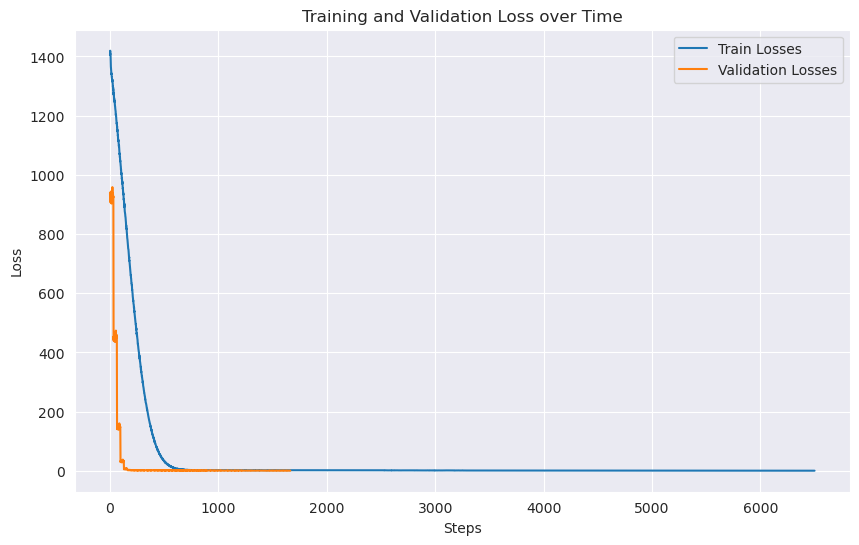

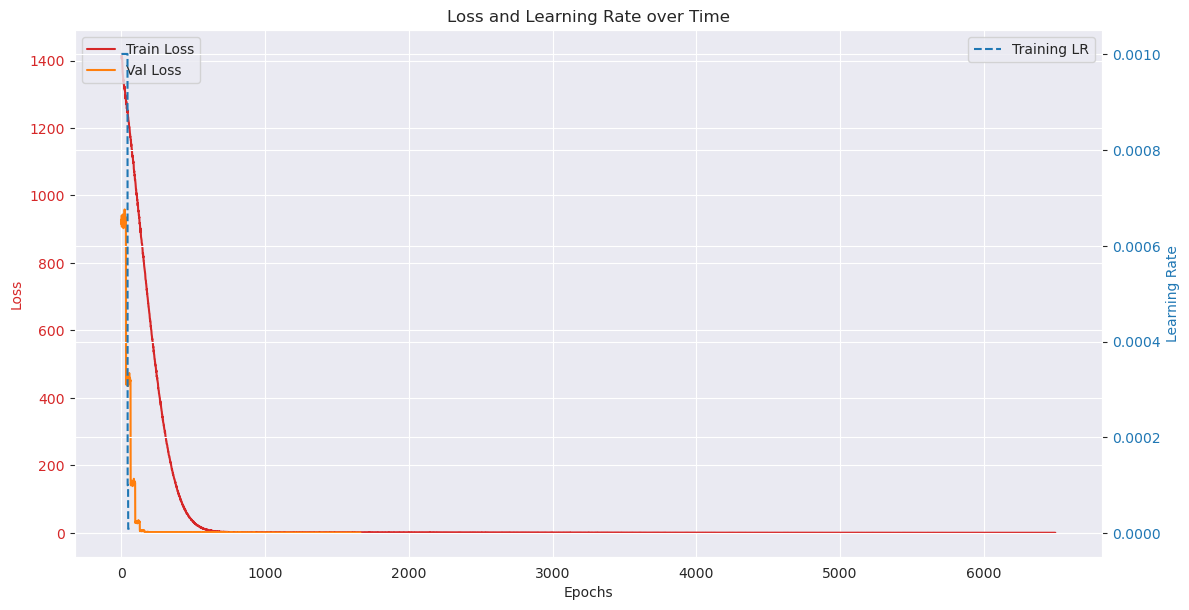

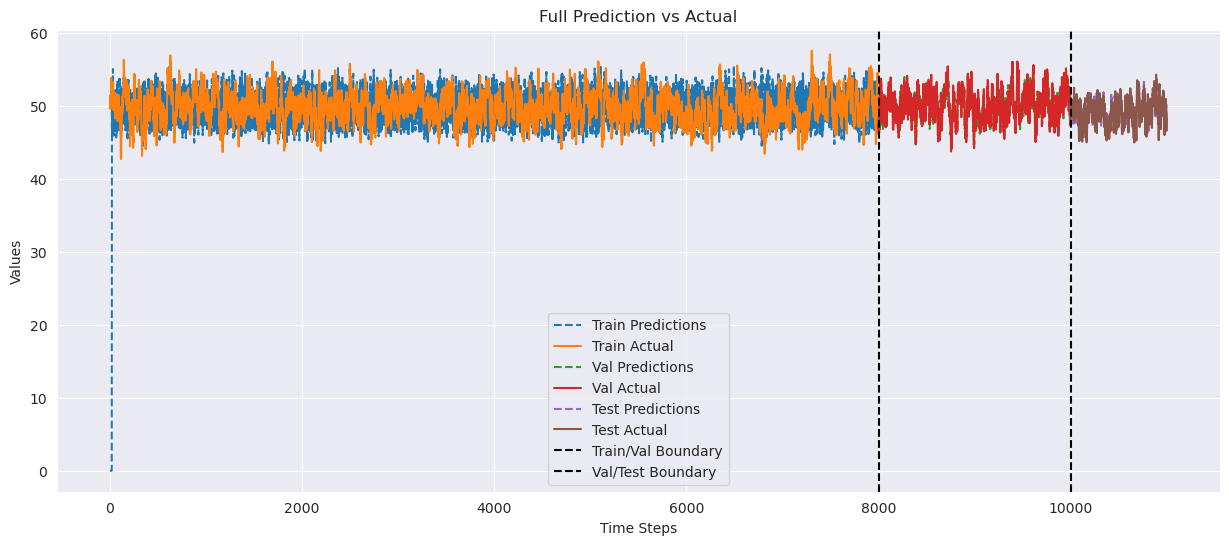

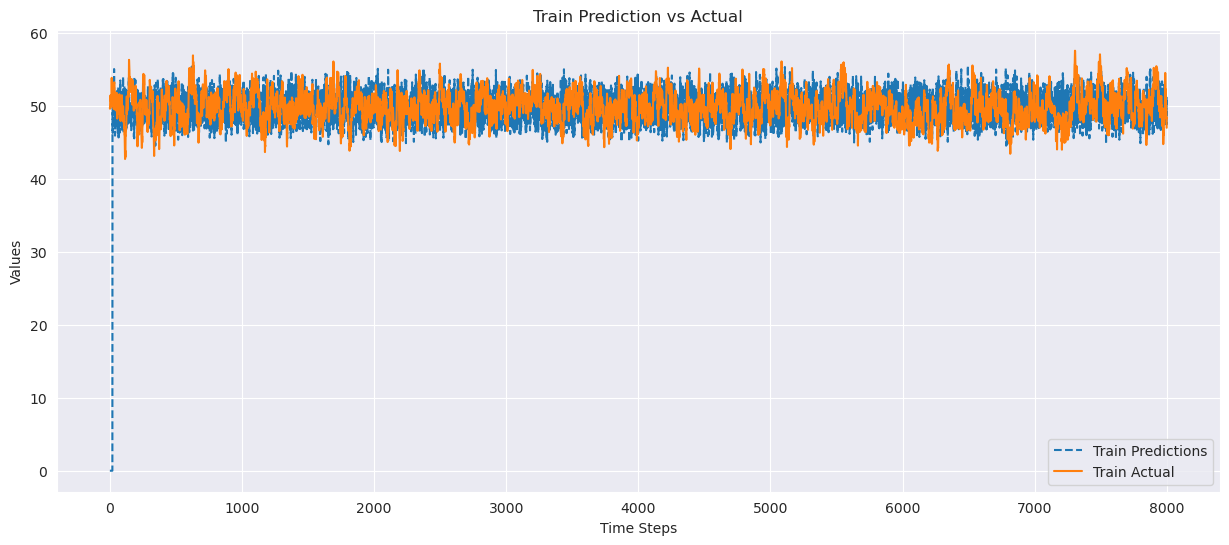

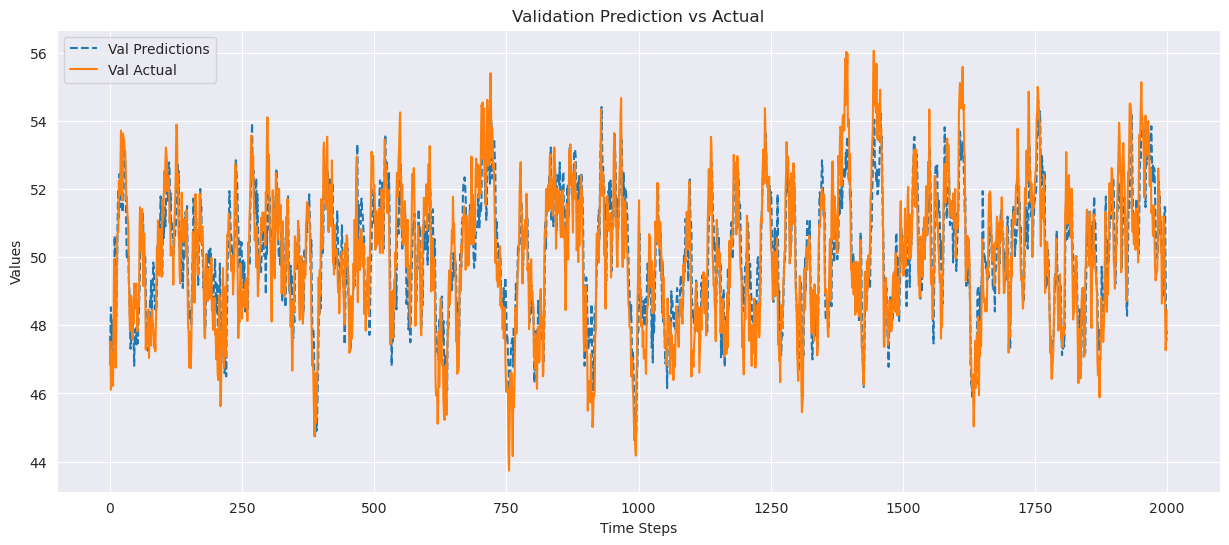

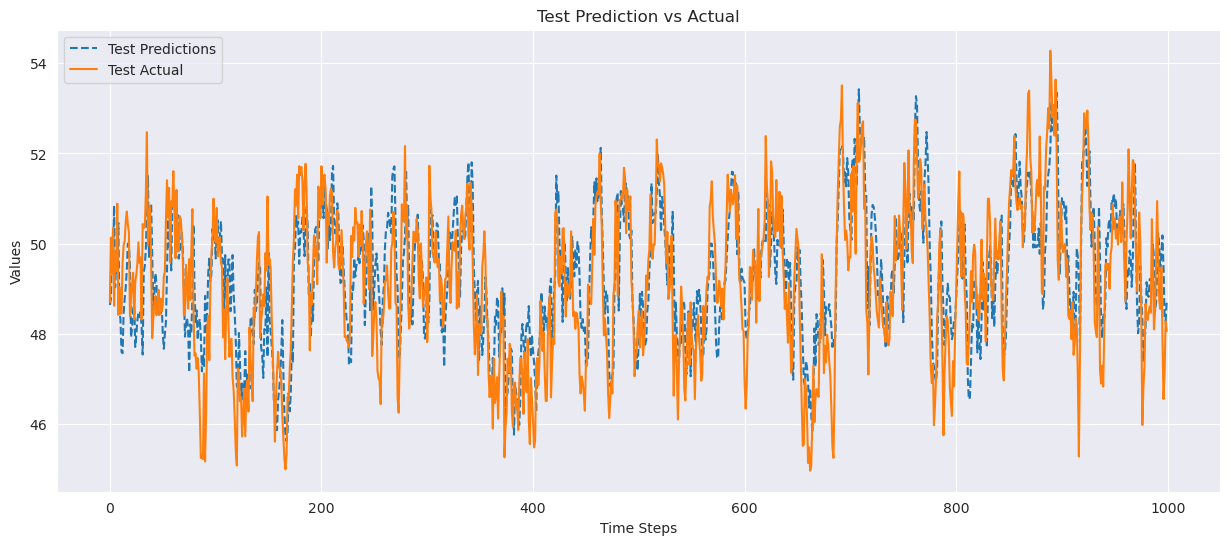

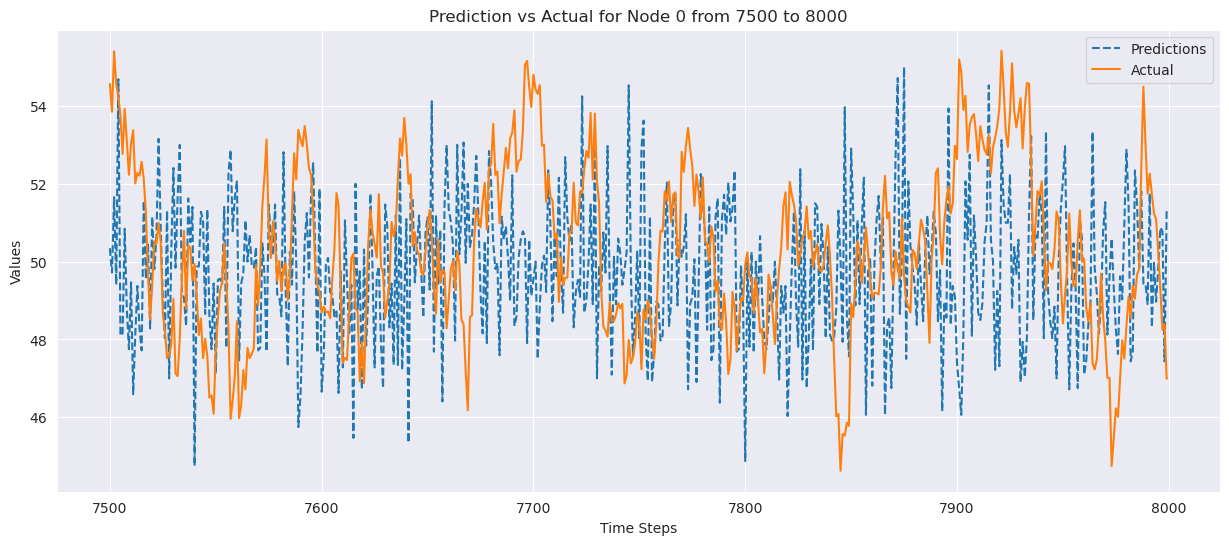

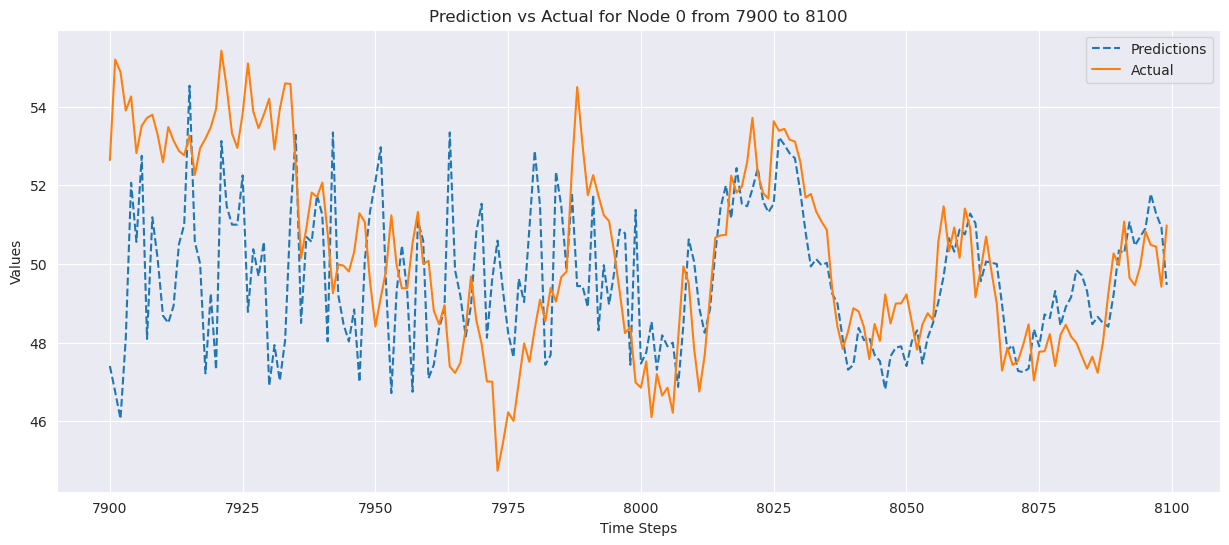

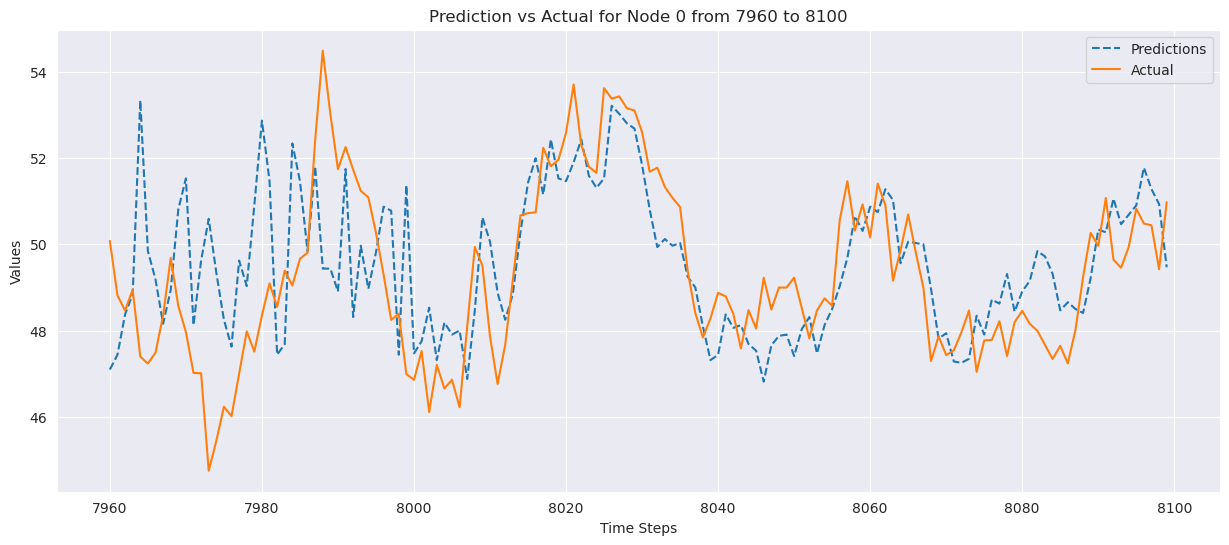

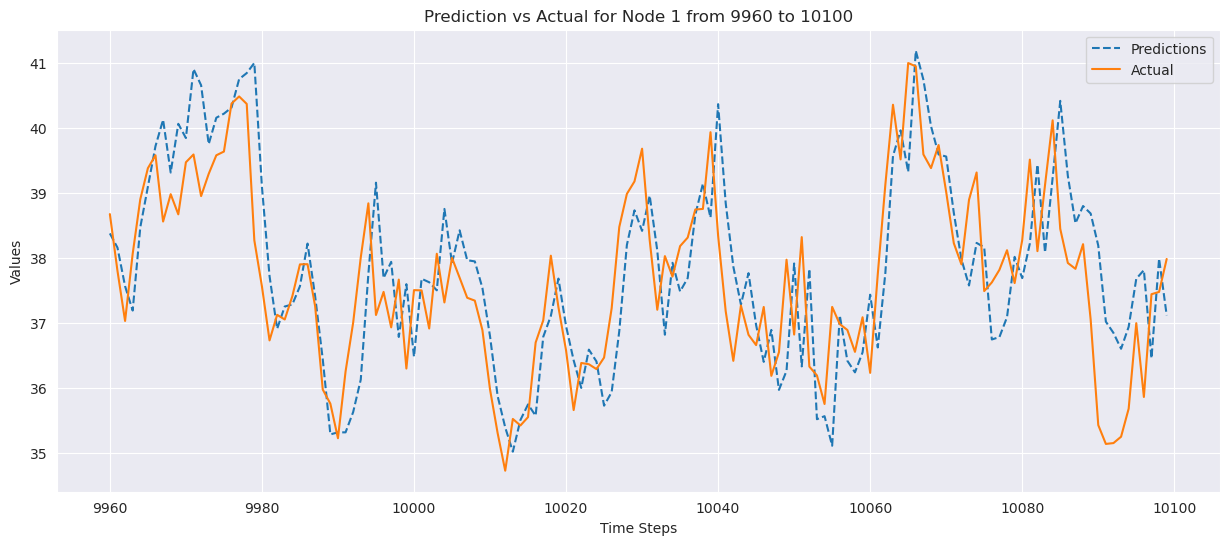

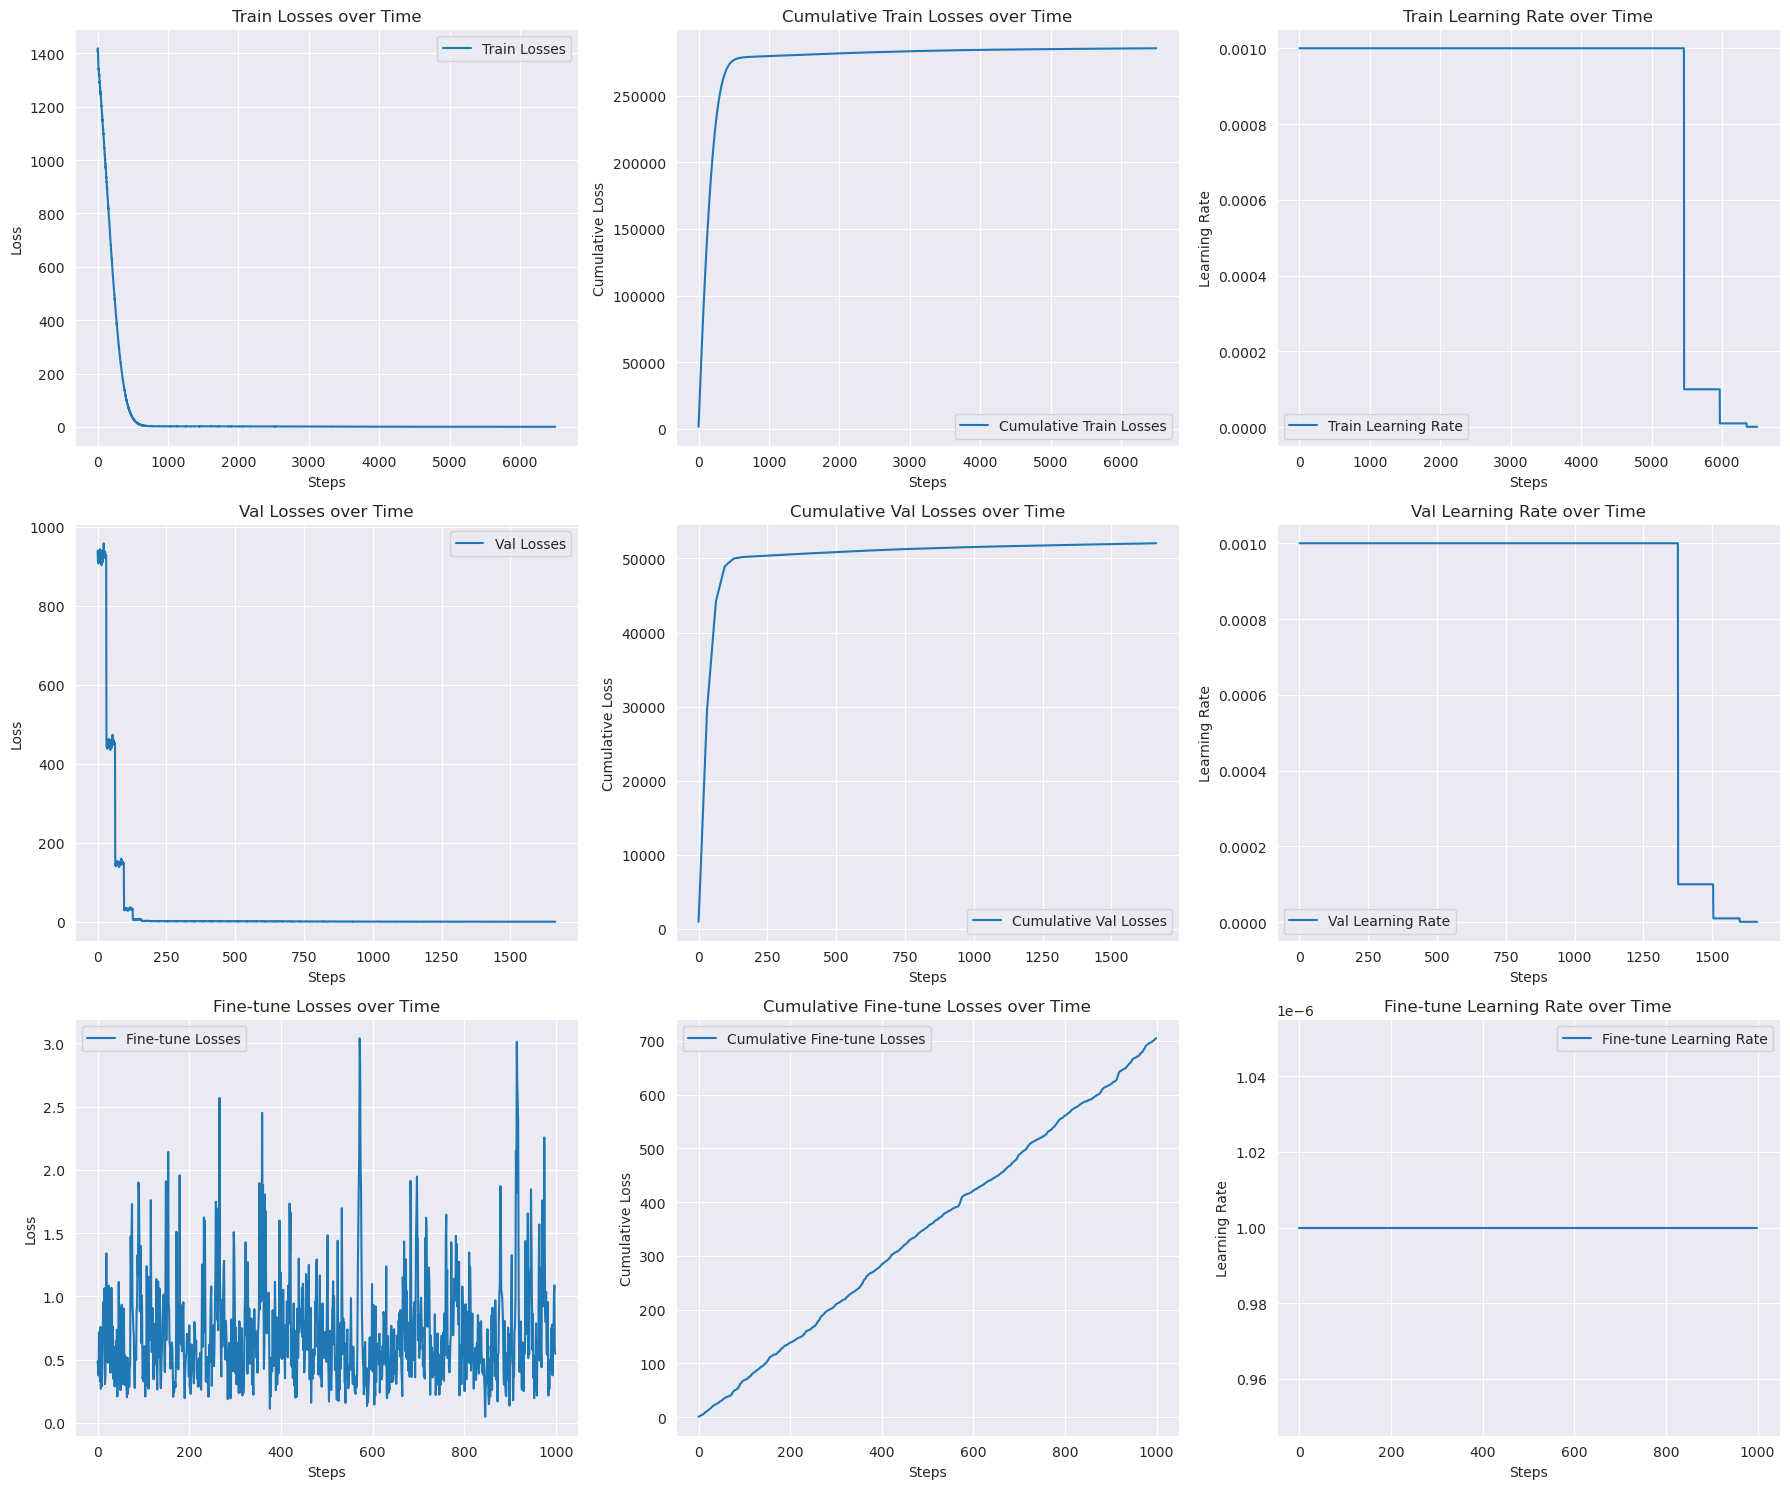

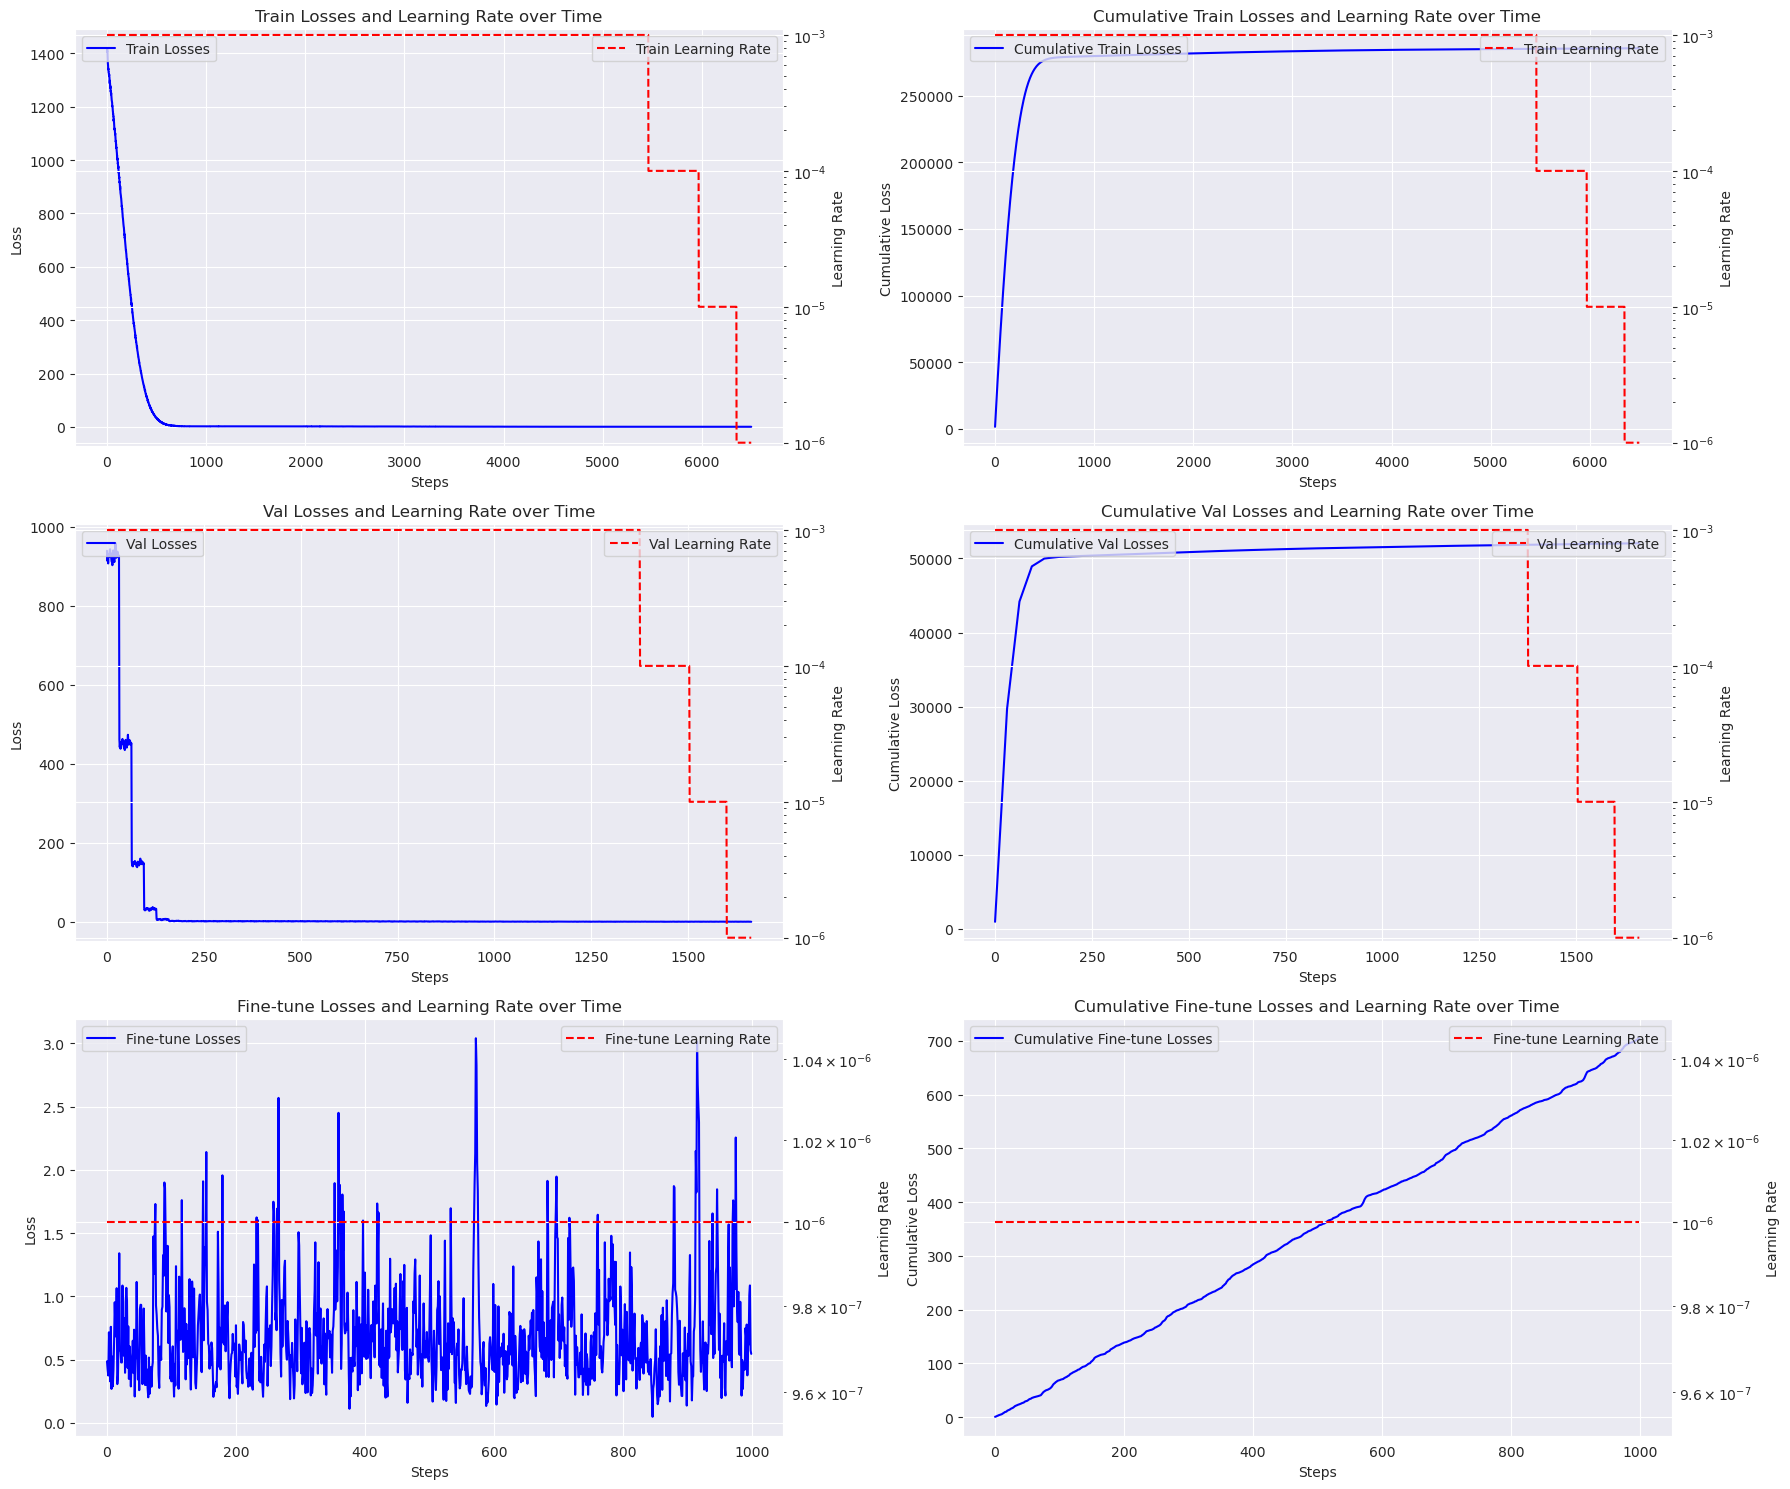

In [142]:
ar1_load_lstm = lstm_train_test(config, ar1_load_data_manager, 'ar1_load')

In [118]:
# iid_latency_lstm = lstm_train_test(config, iid_latency_data_manager, 'iid_latency')

In [117]:
# ar1_latency_lstm = lstm_train_test(config, ar1_latency_data_manager, 'ar1_latency')